In [2]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext watermark
%watermark -m -v -p numpy,matplotlib
print("opencv "+cv2.__version__)
matplotlib.rcParams['savefig.dpi'] = 200

CPython 3.4.0
IPython 2.1.0

numpy 1.8.1
matplotlib 1.3.1

compiler   : GCC 4.8.2
system     : Linux
release    : 3.13.0-34-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
opencv 3.0.0-dev


# Fiducial Recognition
This program uses OpenCV to find a fiducial marking from a for both BBM's and HDI's in an input image.

The procedure is essentially the following:
1. Reduce resolution by a factor of 8 to shorten processing time
2. Use k-means clustering to separate the foreground from the background
3. Dilate the foreground(Fiducial + noise) to close any small holes in image
4. Extract contours from image
5. Filter contours on size and aspect ratio.
6. Assure one and only one countour passes filters
7. Calculate minimum bounding box and centroid of fiducial
8. Return Centroid as fiducial center and distance between centroid and box center as measure of goodness

In [110]:
def getFiducial(filename, dilateSize, sizeMin, sizeMax, shrinkFactor, colorGroups):
    plt.figure()
    
    n = 1
    def doFig(pic):
        nonlocal n
        ax = plt.subplot(2,3,n); n+=1
        plt.imshow(pic, 'gray')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.xticks = None
    
    def doHist(pic):
        nonlocal n
        ax = plt.subplot(2,3,n); n+=1
        plt.hist(pic.ravel(), bins = 50, log = True)
    
    # Load Image from file and resize
    imgRaw = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    imgRaw = cv2.resize(imgRaw, (imgRaw.shape[1]//shrinkFactor,imgRaw.shape[0]//shrinkFactor))
    dims = imgRaw.shape
    pixels = dims[0]*dims[1]
    doFig(imgRaw)
    
    #Do k-means clustering
    criteria = (cv2.TERM_CRITERIA_COUNT + cv2.TERM_CRITERIA_EPS, 10, 1.)
    flags = cv2.KMEANS_PP_CENTERS
    _, labels, centers = cv2.kmeans(np.float32(imgRaw).ravel(),colorGroups, None, criteria, 10, flags)
    foreground = list(centers).index(np.max(centers))
    labels = labels.reshape(imgRaw.shape)
    
    imgFore = imgRaw.copy()
    imgFore[labels != foreground] = 0
    imgFore[labels == foreground] = 1
    doFig(imgFore)
    
    #Dilate Foreground
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilateSize,dilateSize))
    imgMorph = cv2.dilate(imgFore,element)
    doFig(imgMorph)
    
    #Find Countours and filter on size and aspect ratio
    _, contours, _ = cv2.findContours(imgMorph.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    def sizeFilter(contour):
        return  sizeMin < cv2.contourArea(contour)/(pixels) < sizeMax
    def arFilter(contour):
        rect = cv2.minAreaRect(contour)
        ar = rect[1][0]/rect[1][1]
        return 0.9 < ar < 1.1
    contours = filter(sizeFilter, contours)
    contours = filter(arFilter, contours)
    contours = list(contours)
    
    if len(contours) != 1:
        raise Exception("Could not isolate fiducial! {} shapes passed filters".format(len(contours)))
    print("Contour Size: {}".format(cv2.contourArea(contours[0])/pixels))
    
    #Fiducial has been found, calculate centorid and bounding box
    fidContour = contours[0]
    mask = np.zeros(imgMorph.shape,dtype=np.uint8)
    cv2.drawContours(mask,[fidContour],0,(10),-1)
    
    moments = cv2.moments(fidContour)
    centroid = ( moments['m10']/moments['m00'],moments['m01']/moments['m00'] )
    
    rect = cv2.minAreaRect(fidContour)
    box = cv2.boxPoints(rect)
    maskRect = mask.copy()
    box = np.int0(box)
    cv2.drawContours(maskRect, [box], 0, (20), 2 )
    doFig(maskRect)
    
    s =  "Found Fidicial!\n"
    s += "Rect Center = {x},{y}\n".format(x=rect[0][0],y=rect[0][1])
    s += "Centroid Center = {x},{y}".format(x=centroid[0], y=centroid[1])
    print(s)
    
    imgCir = cv2.cvtColor(imgRaw.copy(),cv2.COLOR_GRAY2BGR)
    cv2.circle(imgCir, (int(rect[0][0]), int(rect[0][1])), 2, (0,0,255), thickness=2)   #blue
    cv2.circle(imgCir, (int(centroid[0]), int(centroid[1])), 2, (0,255,0), thickness=2) #green
    doFig(imgCir)
    
    #Calculate Measure of Fit Quality(Heuristic)
    qual = np.sqrt((rect[0][0] - centroid[0])**2 + (rect[0][1] - centroid[1])**2) / dims[0]
    
    return centroid, qual

Contour Size: 0.015514322916666667
Found Fidicial!
Rect Center = 47.04972839355469,56.444759368896484
Centroid Center = 46.95258078052875,56.20324520912015


((46.95258078052875, 56.20324520912015), 0.0010846686329076133)

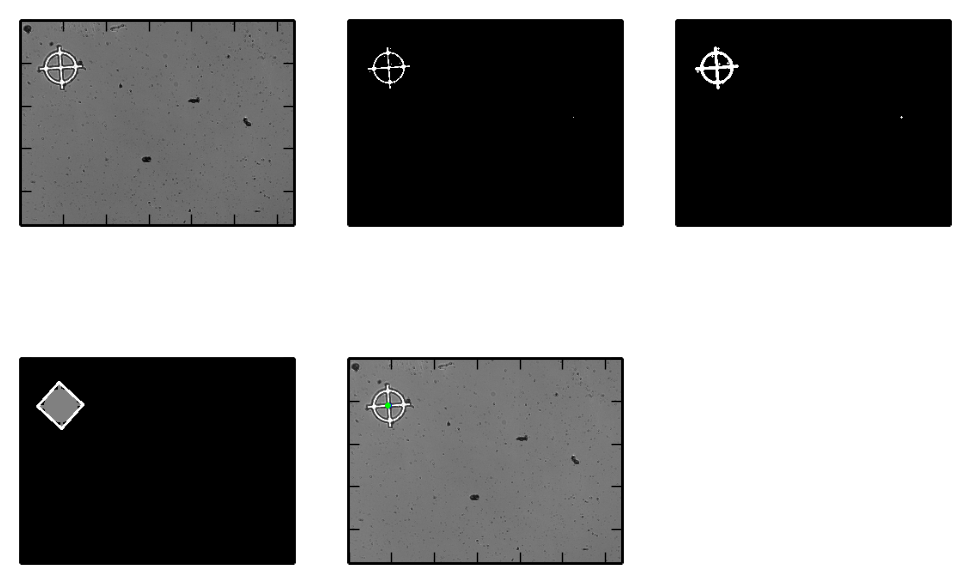

In [111]:
getFiducial("/home/caleb/Sources/Fiducial_Recognition/data/BBM_fiducial7.png", 3, 0.01, 0.02, 8, 3)

Contour Size: 0.25284505208333335
Found Fidicial!
Rect Center = 173.5,108.00000762939453
Centroid Center = 173.9739595403009,108.03427144218142


((173.9739595403009, 108.03427144218142), 0.0019799851584256529)

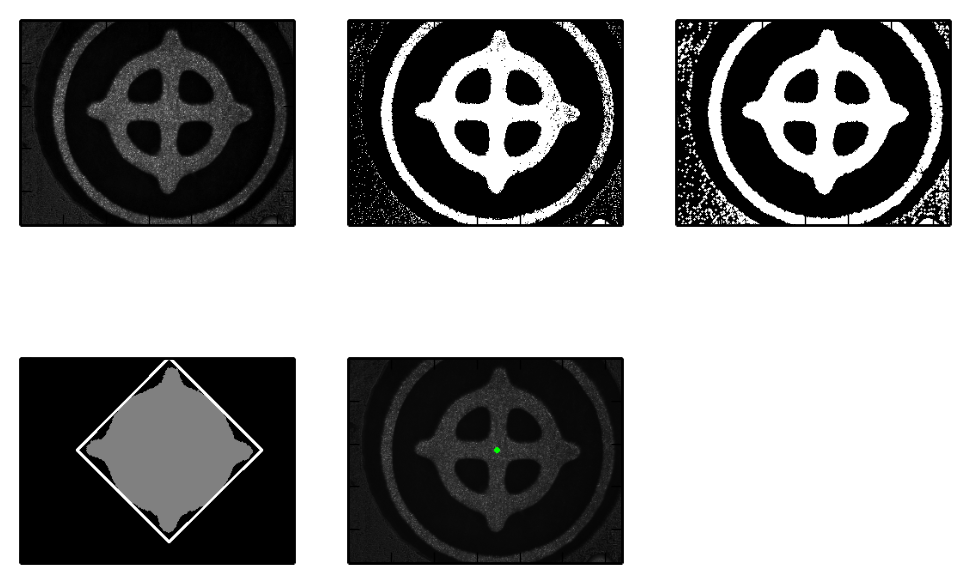

In [122]:
getFiducial("/home/caleb/Sources/Fiducial_Recognition/data/HDIV3_fiducial.png", 3, .23, .26, 8, 2)